In [1]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc,confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

In [10]:
data_dir = "C:\\Users\\henak\\OneDrive\\Desktop\\Source Code Classification\\Language Dataset"
classes = ["C", "C++", "Java", "JavaScript", "Python", "C#"]

In [3]:
# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(classes)

LabelEncoder()

In [4]:
# Parameters
max_seq_length = 500  # Maximum length of code snippet
vocab_size = 20000    # Vocabulary size for tokenization

In [5]:
# Prepare data
def load_data(data_dir, classes):
    X, y = [], []
    for label in classes:
        folder_path = os.path.join(data_dir, label)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                code = f.read()

                X.append(code)
                y.append(label)
    return X, y

In [6]:
def preprocess_data(X, y, tokenizer, max_seq_length, label_encoder):
    # Tokenize text
    tokenizer.fit_on_texts(X)
    X_seq = tokenizer.texts_to_sequences(X)
    X_padded = pad_sequences(X_seq, maxlen=max_seq_length, padding="post")
    
    # Encode labels
    y_encoded = label_encoder.transform(y)
    y_categorical = to_categorical(y_encoded)
    return X_padded, y_categorical


In [7]:
# Load and preprocess
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
X, y = load_data(data_dir, classes)
X_padded, y_categorical = preprocess_data(X, y, tokenizer, max_seq_length, label_encoder)

In [8]:
# Model parameters
embedding_dim = 128
num_classes = len(classes)

# Define LRCN model
def build_lrcn_model(vocab_size, embedding_dim, max_seq_length, num_classes):
    inputs = Input(shape=(max_seq_length,))
    x = Embedding(vocab_size, embedding_dim)(inputs)
    x = Conv1D(128, kernel_size=3, activation="relu")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = LSTM(128, return_sequences=False)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Build the model
model = build_lrcn_model(vocab_size, embedding_dim, max_seq_length, num_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 500, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 498, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 249, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,749,510 (10.49 MB)

 Trainable params: 2,749,510 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 173s 251ms/step - accuracy: 0.2410 - loss: 1.6373 - val_accuracy: 0.2670 - val_loss: 1.5959
Epoch 2/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 178s 262ms/step - accuracy: 0.2419 - loss: 1.6074 - val_accuracy: 0.2686 - val_loss: 1.5951
Epoch 3/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 179s 263ms/step - accuracy: 0.2721 - loss: 1.5680 - val_accuracy: 0.4841 - val_loss: 1.1133
Epoch 4/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 177s 260ms/step - accuracy: 0.5738 - loss: 0.9395 - val_accuracy: 0.7476 - val_loss: 0.4966
Epoch 5/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 189s 277ms/step - accuracy: 0.7593 - loss: 0.4940 - val_accuracy: 0.8896 - val_loss: 0.3182
Epoch 6/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 173s 255ms/step - accuracy: 0.9175 - loss: 0.2659 - val_accuracy: 0.9327 - val_loss: 0.2168
Epoch 7/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 173s 255ms/step - accuracy: 0.9540 - loss: 0.1551 - val_accuracy: 0.9391 - val_loss: 0.2047
Epoch 8/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 171s 252ms/step - accuracy: 0.9686 -

In [27]:
# Evaluate
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy:.2f}")

# Predict
sample_code = "def hello_world():\n    print('Hello, world!')"  # Python example
sample_seq = tokenizer.texts_to_sequences([sample_code])
sample_padded = pad_sequences(sample_seq, maxlen=max_seq_length, padding="post")
prediction = model.predict(sample_padded)
predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
print(f"Predicted Label: {predicted_label[0]}")


170/170 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9465 - loss: 0.1980
Validation Accuracy: 0.94
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Predicted Label: Python


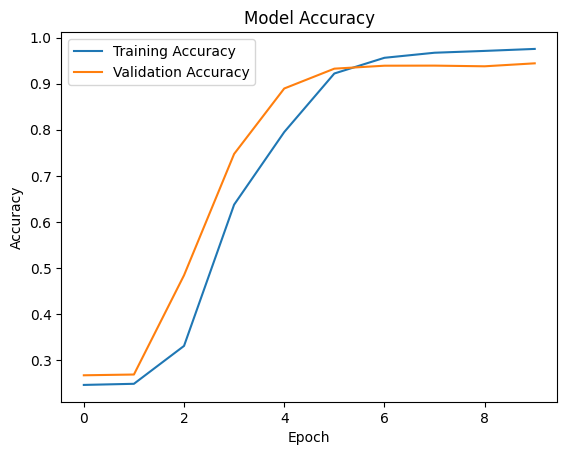

In [33]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

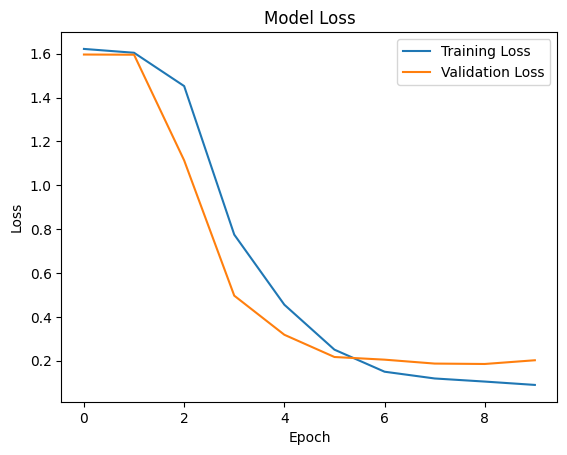

In [34]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [39]:
y_pred_prob = model.predict(X_val)
# One-hot encode y_val
y_val_binary = label_binarize(y_val, classes=[0, 1, 2, 3, 4, 5])  # Adjust the number of classes accordingly
n_classes = y_val_binary.shape[1]

# Compute PR and ROC for each class
precision = {}
recall = {}
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_val_binary[:, i], y_pred_prob[:, i])
    fpr[i], tpr[i], _ = roc_curve(y_val_binary[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step


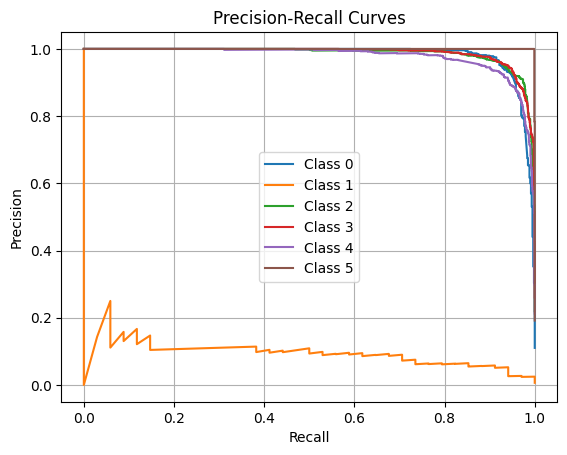

In [40]:
plt.figure()
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Class {i}')
plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.grid()
plt.show()

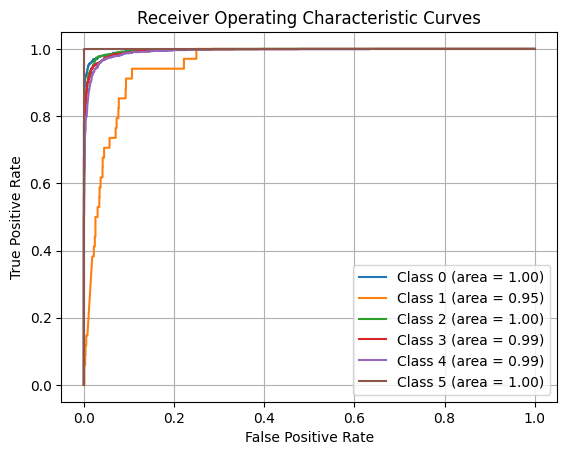

In [41]:
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.title('Receiver Operating Characteristic Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid()
plt.show()


170/170 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step


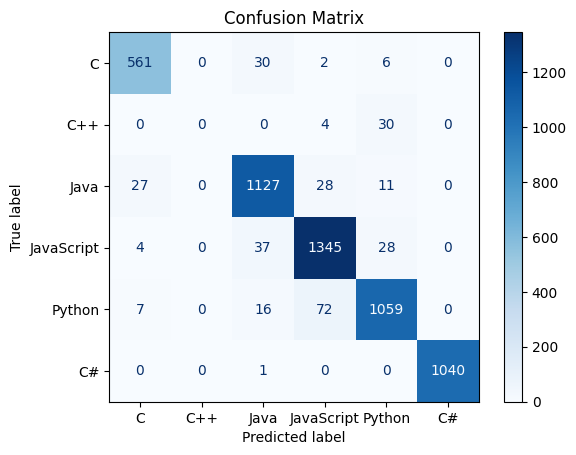

In [44]:
y_pred = np.argmax(model.predict(X_val), axis=1)
y_val_classes = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_val_classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [47]:
# Print classification report for precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_val_classes, y_pred, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

           C       0.94      0.94      0.94       599
         C++       0.00      0.00      0.00        34
        Java       0.93      0.94      0.94      1193
  JavaScript       0.93      0.95      0.94      1414
      Python       0.93      0.92      0.93      1154
          C#       1.00      1.00      1.00      1041

    accuracy                           0.94      5435
   macro avg       0.79      0.79      0.79      5435
weighted avg       0.94      0.94      0.94      5435



C:\Users\henak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\henak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\henak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati